# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data.head()) #вывод первых 5 строк
print(data.info()) #вывод инфо о столбцах и значениях в них


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

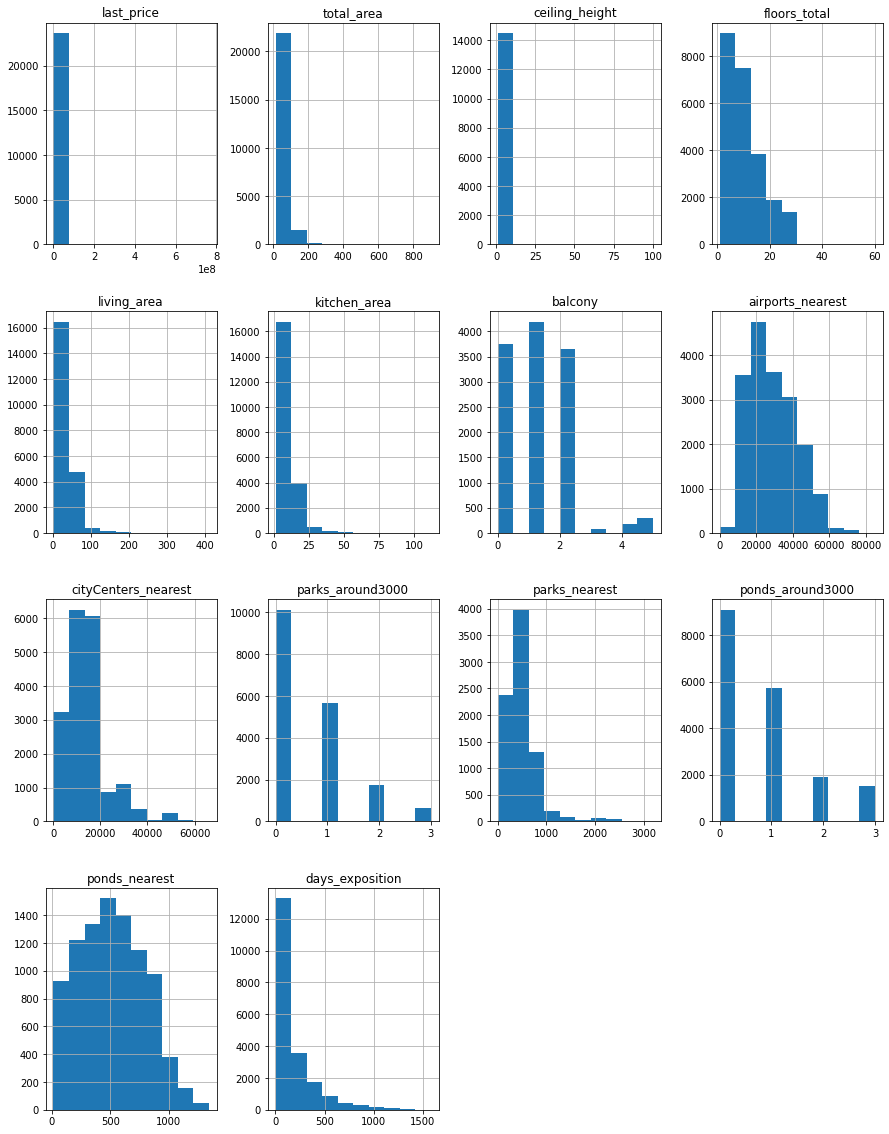

In [2]:
import matplotlib.pyplot as plt
#создала датафрейм, где только числовые объекты, чтобы построить гистограммы только для них
all_data = pd.DataFrame()
for column in data.columns: 
    if data[column].dtype in ['float64','str64']:
        all_data[column] = data[column]

#гистограммы для числовых объектов        
all_data.hist(figsize=(15, 20)) 
plt.show()


Анализ представленных числовых данных проведен ниже в других пунктах задания.

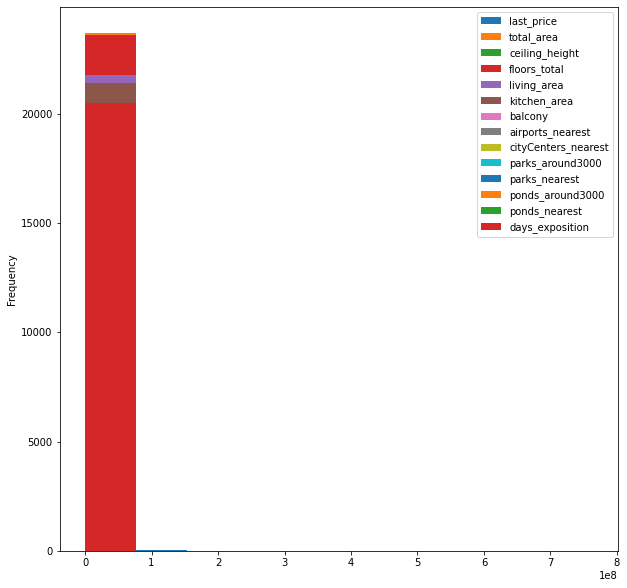

In [3]:
#все на одном графике, как запрашивается в задании, выглядит неудобно и неинформативно за счет разного порядка числ
all_data.plot(kind='hist',figsize=(10, 10)) 
plt.show()


### Выполните предобработку данных

In [4]:
#проверка всего пропусков
display('***Всего пропусков***',data.isna().sum()) 
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')


'***Всего пропусков***'

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


In [5]:
print(data.duplicated().sum())

0


Явные дубликаты не найдены

In [6]:
#заменила NaN на 0, так как вероятно кол-во балконов не заполнялось в случае их отсутствия
data['balcony'] = data['balcony'].fillna(0) 

#проверила уникальные значения в столбце апартаменты ли это
display('*Уникальные значения в столбце Апартаментов*', data['is_apartment'].value_counts())
#NaN скорее всего соответствует False 
data['is_apartment'] = data['is_apartment'].fillna(False)

#было предположение, что это совсем свежие объявления, которые не были закрыты, но в списке есть объявления от 14 года
display('*Позиции без продолжительности*',data.query('days_exposition.isna()').sort_values(by='first_day_exposition').head()) 

'*Уникальные значения в столбце Апартаментов*'

False    2725
True       50
Name: is_apartment, dtype: int64

'*Позиции без продолжительности*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3873,7,20100000.0,117.6,2014-11-27T00:00:00,3,NaN,8.0,62.5,7,False,...,21.5,0.0,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,NaN
15857,6,25000000.0,145.2,2014-11-27T00:00:00,3,NaN,5.0,60.7,5,False,...,40.2,0.0,Санкт-Петербург,36779.0,14931.0,0.0,NaN,0.0,NaN,NaN
3291,8,8200000.0,52.5,2014-11-27T00:00:00,1,NaN,8.0,21.5,2,False,...,15.1,0.0,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,NaN
6922,17,29999000.0,133.5,2014-12-08T00:00:00,3,3.0,15.0,71.7,12,False,...,19.8,2.0,Санкт-Петербург,31656.0,8733.0,1.0,562.0,1.0,522.0,NaN
15614,3,19400000.0,117.7,2014-12-09T00:00:00,3,3.0,8.0,62.6,5,False,...,21.3,0.0,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,NaN


Заменила NaN на 0, так как вероятно кол-во балконов не заполнялось в случае их отсутствия. В случае апартаментов незаполненные NaN скорее всего соответствует False - то есть отрицальному ответу на название столбца.

In [7]:
#изменила формат времени для наглядности и будующей работы со столбцом
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')


In [8]:
#изменила формат балконов на целый
data['balcony'] = data['balcony'].astype('int')


In [9]:
#изменила формат этажей на целый
data['floors_total'] = data['floors_total'].fillna(0)
data['floors_total'] = data['floors_total'].astype('int')


In [10]:
#создала новый столбец, чтобы не искажать данные в изначальном
data['floors_total_adj'] = data['floors_total'].fillna(0)
#кол-во этаже всего будет не меньше, чем этаж квартиры - для анализа
data.loc[data['floors_total_adj'] == 'None','floors_total_adj'] = data['floor']


Создала новый столбец, в котором все пропущенные значения в столбце этажности заменила на номер этажа, на котором находится квартира, так как значение в столбце этажности в любом случае не будет выше, а медиана может исказить данные в этом случае.

In [11]:
#проверка уникальных значений в столбце parks_around3000
display('***Уникальные значения в столбце парков***', data['parks_around3000'].unique())

#пивот для проверки возможных искажений в парках
parks = data.pivot_table(index='locality_name',columns='parks_around3000',values='parks_nearest',aggfunc='sum')
display('***Пивот по наличию парков в населенных пунктах***', parks.head(10))
#ошибка в данных по СПБ, парков рядом 0, однако растояние до парков указано - всего 4 строки 
display('***Проверка ошибки в парках в СПБ***', data.query('parks_around3000 == 0 and (locality_name in "Санкт-Петербург" and parks_nearest>0)')) 
#изначально думала удалить строки, но потом решила оставить с целью полноты другой информации и 4 строки - несущественны
##wrong_parks = data.query('parks_around3000 == 0 and (locality_name in "Санкт-Петербург" and parks_nearest>0)') 
##data = data.drop(wrong_parks.index)

#поправила растояние до парка на 0 в 4х найденных строках, за эталон был взят столбец parks_around3000
data.loc[(data['parks_around3000'] == 0) & (data['locality_name'] != 'Санкт-Петербург'), 'parks_nearest'] = 0 
#поправила 8376 строк, по которым были пропуски в parks_nearest и 0 в parks_around3000
data.loc[(data['parks_nearest'].isna()) & (data['parks_around3000'] == 0), 'parks_nearest'] = 0 


'***Уникальные значения в столбце парков***'

array([ 1.,  0.,  2., nan,  3.])

'***Пивот по наличию парков в населенных пунктах***'

parks_around3000,0.0,1.0,2.0,3.0
locality_name,,,,
Зеленогорск,0.0,NaN,1148.0,2222.0
Колпино,0.0,55322.0,7878.0,2699.0
Красное Село,0.0,10435.0,5941.0,5064.0
Кронштадт,0.0,12666.0,10004.0,5568.0
Ломоносов,0.0,17.0,5924.0,284.0
Павловск,0.0,3030.0,3589.0,3249.0
Петергоф,0.0,40896.0,6681.0,12420.0
Пушкин,0.0,71498.0,8714.0,5499.0
Санкт-Петербург,12457.0,2872586.0,584356.0,162388.0


'***Проверка ошибки в парках в СПБ***'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
1590,3,7500000.0,70.0,2017-07-11,2,NaN,18,37.0,13,False,...,0,Санкт-Петербург,14878.0,9791.0,0.0,3064.0,1.0,264.0,4.0,18
10959,9,3000000.0,31.1,2017-03-21,1,NaN,5,17.7,2,False,...,0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0,5
19208,17,14950000.0,187.0,2017-10-12,5,3.0,2,80.0,2,False,...,1,Санкт-Петербург,36805.0,8656.0,0.0,3013.0,3.0,537.0,49.0,2
19430,9,3900000.0,30.5,2018-02-22,1,2.6,5,16.5,1,False,...,0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0,5


Благодаря пивоту по наличию парков в населенных пунктах было выявлено несоответствие столбцов parks_around3000 и parks_nearest, отсутствие парков вокруг соответствовало расстоянию до ближайших парков. Данные в этих 4 строках в столбце parks_nearest были заменены на 0. Также заменила пропуски в parks_nearest на 0, где кол-во парков вокруг соответствовало 0. Принимая 0 в parks_nearest за отсутствие парков, так как изначально мин число в данном столбце = 1, то есть в парках никто не живет, путаницы не будет.

In [12]:
#определили уникальные значения
print(data['ponds_around3000'].unique())
#проверила, что нет данных, где число водоёмов =0, а растояние больше нуля
print('Кол-во строк, где число водоемов = 0, но есть значения в столбце водоемов рядом: ', len(data.query('ponds_around3000 == 0 and ponds_nearest>0')))
#Nan заменила на 0 в столбце радиуса по водоемам, по которым было 0 в кол=ве
data.loc[(data['ponds_around3000'] == 0), 'ponds_nearest'] = 0 
#проверили, что все NaN в кол-ве водоемов имеют NaN в радиусе, всего строк 5518, что равно кол-ву NaN в проверке всего датафрейма
print('Проверка совпадения пропусков в парках вокруг и парков рядом: ', len(data.query('ponds_around3000.isna() and ponds_nearest.isna()')))

[ 2.  0.  3.  1. nan]
Кол-во строк, где число водоемов = 0, но есть значения в столбце водоемов рядом:  0
Проверка совпадения пропусков в парках вокруг и парков рядом:  5518


То же самое сделала с водоемами. Принимая 0 в ponds_nearest за отсутствие парков, так как изначально мин число в данном столбце = 13, то есть в прудах также никто не живет, путаницы не будет.

In [13]:
#проверили позиции без локации - 49 строк было
display('*Строки без локации*', data.query('locality_name.isna()').head())
#заменили на 'Локация_не_определена', так как определить локацию по косвенным признакам не получилось
data['locality_name'] = data['locality_name'].fillna('Локация_не_определена') 
display(data.query('locality_name == "Локация_не_определена"').head()) #для проверки


'*Строки без локации*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
1097,3,8600000.0,81.7,2016-04-15,3,3.55,5,50.8,2,False,...,0,NaN,23478.0,4258.0,0.0,0.0,0.0,0.0,147.0,5
2033,6,5398000.0,80.0,2017-05-30,3,NaN,4,42.6,2,False,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,4
2603,20,3351765.0,42.7,2015-09-20,1,NaN,24,15.6,3,False,...,0,NaN,22041.0,17369.0,0.0,0.0,1.0,374.0,276.0,24
2632,2,5130593.0,62.4,2015-10-11,2,NaN,24,33.1,21,False,...,0,NaN,22041.0,17369.0,0.0,0.0,1.0,374.0,256.0,24
3574,10,4200000.0,46.5,2016-05-28,2,NaN,5,30.8,5,False,...,0,NaN,27419.0,8127.0,0.0,0.0,1.0,603.0,45.0,5


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
1097,3,8600000.0,81.7,2016-04-15,3,3.55,5,50.8,2,False,...,0,Локация_не_определена,23478.0,4258.0,0.0,0.0,0.0,0.0,147.0,5
2033,6,5398000.0,80.0,2017-05-30,3,NaN,4,42.6,2,False,...,0,Локация_не_определена,NaN,NaN,NaN,NaN,NaN,NaN,34.0,4
2603,20,3351765.0,42.7,2015-09-20,1,NaN,24,15.6,3,False,...,0,Локация_не_определена,22041.0,17369.0,0.0,0.0,1.0,374.0,276.0,24
2632,2,5130593.0,62.4,2015-10-11,2,NaN,24,33.1,21,False,...,0,Локация_не_определена,22041.0,17369.0,0.0,0.0,1.0,374.0,256.0,24
3574,10,4200000.0,46.5,2016-05-28,2,NaN,5,30.8,5,False,...,0,Локация_не_определена,27419.0,8127.0,0.0,0.0,1.0,603.0,45.0,5


In [14]:
#Создала переменную, в которую поместила сред по NaN в парках, аэропортах, прудах и центрах
strange_rows = data.query('cityCenters_nearest.isna() and airports_nearest.isna() and parks_around3000.isna() and ponds_around3000.isna()')
display('*Подозрительные строки*',strange_rows.head())


'*Подозрительные строки*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,12
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,27
12,10,3890000.0,54.00,2016-06-30,2,NaN,5,30.00,5,False,...,0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0,5
22,20,5000000.0,58.00,2017-04-24,2,2.75,25,30.00,15,False,...,2,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,25
30,12,2200000.0,32.80,2018-02-19,1,NaN,9,NaN,2,False,...,0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,9


Оставшиеся объекты в кол-ве 5518 штук, по которым нет иформации ни о парках, ни о прудах не удаляла и не меняла их, но объединила в срез подозрительные строки. Подозрительные строки не трогала и не заполняла, данные позиции вносятся в систему автоматически согласно информации выше, заполнять их медианой не имеет смысла для анализа - они будут средними из средних. Не учитываю эти строки в анализе пропущенных параметров. 

In [15]:
#вывела строку, которая не относится к strange_rows
display('*NaN центров города из числа неподозрительных строк*',data.query('cityCenters_nearest.isna() and parks_around3000>=0')) 
#посмотрели на разброс цифр в Пушкине, чтобы понять чем заменить пропуск
display('*Пушкин по удаленности от центра*',data.query('locality_name == "Пушкин"').sort_values(by='cityCenters_nearest').head()) 
#вместо одного NaN поставила медианное значение
data.loc[(data['cityCenters_nearest'].isna()) & (data['parks_around3000'] >= 0), 'cityCenters_nearest'] = data.query('locality_name == "Пушкин"')['cityCenters_nearest'].median()

#все аэропорты, которые не относятся к strange_rows, в СПБ
display('*NaN аэропортов из числа неподозрительных строк*',data.query('airports_nearest.isna() and parks_around3000>=0').head()) 
#слишком большой разброс по удаленности, не правила данные оставила как есть - NaN
display('*СПБ по удаленности аэропортов*',data.query('locality_name == "Санкт-Петербург" and airports_nearest>0').sort_values(by='airports_nearest').head()) 
display('*СПБ описание значениий строк*',data.query('locality_name == "Санкт-Петербург" and airports_nearest>0')['airports_nearest'].describe())


'*NaN центров города из числа неподозрительных строк*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
20190,2,10500000.0,85.0,2019-01-08,3,3.0,3,55.5,2,False,...,1,Пушкин,15527.0,NaN,1.0,134.0,0.0,0.0,NaN,3


'*Пушкин по удаленности от центра*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
2354,1,3500000.0,36.8,2017-11-02,1,2.5,9,18.6,5,False,...,1,Пушкин,12157.0,24311.0,1.0,94.0,1.0,1025.0,130.0,9
21640,18,3500000.0,35.2,2017-01-24,1,NaN,5,14.0,3,False,...,1,Пушкин,12383.0,24537.0,1.0,630.0,0.0,0.0,56.0,5
20813,3,6200000.0,72.5,2017-07-20,3,NaN,6,41.0,2,False,...,2,Пушкин,12391.0,24545.0,1.0,122.0,1.0,565.0,58.0,6
5167,19,9973000.0,88.0,2017-12-21,3,2.8,4,50.0,3,False,...,0,Пушкин,12489.0,24643.0,1.0,690.0,0.0,0.0,7.0,4
6644,15,3899000.0,38.0,2017-04-27,1,NaN,4,18.0,1,False,...,0,Пушкин,12489.0,24643.0,1.0,690.0,0.0,0.0,67.0,4


'*NaN аэропортов из числа неподозрительных строк*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
733,18,18700000.0,109.7,2018-02-03,3,2.75,21,57.2,13,False,...,1,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,0.0,112.0,21
974,8,25897000.0,149.0,2018-03-26,4,2.74,7,NaN,6,False,...,0,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,90.0,7
2415,17,9500000.0,67.4,2017-04-15,2,2.80,23,37.6,4,False,...,0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,0.0,56.0,23
7521,16,43500000.0,245.8,2015-12-17,3,4.45,7,170.8,7,True,...,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,0.0,1067.0,7
7542,10,6900000.0,50.0,2016-03-17,1,2.80,23,20.0,12,False,...,0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,0.0,317.0,23


'*СПБ по удаленности аэропортов*'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
4017,7,2268000.0,35.0,2017-12-21,1,NaN,9,14.0,6,False,...,0,Санкт-Петербург,6450.0,17461.0,0.0,0.0,1.0,444.0,25.0,9
12899,8,4199000.0,56.0,2017-12-21,2,NaN,9,27.0,5,False,...,0,Санкт-Петербург,6450.0,17461.0,0.0,0.0,1.0,444.0,24.0,9
7778,9,2750000.0,29.0,2017-02-19,1,2.5,4,15.0,1,False,...,0,Санкт-Петербург,6914.0,21486.0,1.0,215.0,0.0,0.0,43.0,4
23150,3,6490000.0,62.5,2015-03-18,2,NaN,24,33.5,15,False,...,4,Санкт-Петербург,6949.0,13165.0,1.0,711.0,0.0,0.0,917.0,24
15633,4,6420000.0,67.0,2015-09-18,2,NaN,24,38.0,11,False,...,1,Санкт-Петербург,6989.0,13205.0,1.0,535.0,0.0,0.0,311.0,24


'*СПБ описание значениий строк*'

count    15635.000000
mean     28047.980045
std      11555.256446
min       6450.000000
25%      18585.000000
50%      26758.000000
75%      36614.000000
max      54784.000000
Name: airports_nearest, dtype: float64

Вне подозрительных строк была обнаружена позиция без удаленности от центра города в Пушкине - заполнила ее медианой. Тоже самое планировала сделать с аэропортами, но разброс данных был очень большой, поэтому не заполняла. Для анализа отдельно данных параметров медианные заполненные значения не повлияют на анализ.

In [16]:
#Заменили NaN в столбце living_area
data.loc[data['living_area'].isna(), 'living_area'] = (data.query('living_area >0')['living_area'].median()/data.query('living_area >0')['total_area'].median())*data['total_area']
#Заменили NaN в столбце kitchen_area
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (data.query('kitchen_area >0')['kitchen_area'].median()/data.query('kitchen_area >0')['total_area'].median())*data['total_area']

Жилая площадь и площадь кухни так или иначе будет зависеть от общей площади. Общая площадь точно будет включать в себя и жилую площадь и кухонную зону и балконы с коридорами и сан.узлами. Поэтому пропуски были заполнены в пропорции к общей площади. Доли кухни к общей площади и жилой площади к общей площади были получена на основании медианных значений по столбцам с исключением пропущенных значений.

In [17]:
#создала словарь с медианой по каждому населенному пункту
median_height = data.groupby('locality_name').agg({'ceiling_height':'median'}).round(1).to_dict()
#создала функцию, которая присваивает высоту потолка в соответствии с городом
def median_height_set(row):
    row['ceiling_height'] = median_height['ceiling_height'][row['locality_name']]
    return row
data[data['ceiling_height'].isna()] = data[data['ceiling_height'].isna()].apply(median_height_set, axis=1)
#так как по ряду нас. пунктов вообще не было значений, присвоила им общую медиану
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data.query('ceiling_height > 0')['ceiling_height'].median()
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_total_adj
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,16
1,7,3350000.0,40.4,2018-12-04,1,2.60,11,18.600000,1,False,...,2,посёлок Шушары,12817.0,18603.0,0.0,0.0,0.0,0.0,81.0,11
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.300000,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,5
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,91.730769,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,14


Исправила пропуски на медиану в разрезе каждого города, оставшиеся пропуски по городам, по которым не было значений, заполнила общей медианой.


In [18]:
#создала новый столбец, в котором будут содержаться поправленные названия населенных пунктов
data['corrected_name'] = data['locality_name']

print('Всего уникальных значений: ',len(data['corrected_name'].unique())) #365 уникальных значений

#Заметила, что причины неявных дупликатов повторяются, следующие несоответствия были найдены и поправлены
data['corrected_name'] = (data['corrected_name']
    .replace('ё', 'е', regex=True)
    .replace('поселок городского типа', 'поселок', regex=True)
    .replace('городской поселок', 'поселок', regex=True)
    .replace('коттеджный поселок', 'поселок', regex=True)
    .replace('поселок при железнодорожной станции', 'поселок станции', regex=True)
)

print('Всего уникальных значений после замены: ',len(data['corrected_name'].unique())) #320 уникальных значений


Всего уникальных значений:  365
Всего уникальных значений после замены:  320


Заметила, что часто встречаются  дубликаты где разнятся 'посёлок' и 'поселок', поэтому буква ё была заменена на е. Также точечно удалось найти совпадения, где тип населенного пункта был написал более и менее подробно. Кол-во уникальных значений было сокращено с 365 до 320 в столбце локации - для изменений использовала новый столбец. 

**Промежутоный вывод:** Явных дубликатов в датасете не было, пропущенные значения разделились на те, что были пропущены ввиду 
- программных ошибок (5518 строк были выделены в отдельную таблицу для удобного извлечения их из аналитики в дальнейшем);
- человеческого фактора - несоответствия в названиях были устранены, пропуски в заполненных данных были заполнены в соответствии с логикой, описанной выше. 

Строки с неверными данными, которые не входят в число 5518 строк, не были удалены мной в виду несущественности их количества.

### Добавьте в таблицу новые столбцы

In [19]:
#цена одного квадратного метра = стоимость объекта / его общую площадь
data['sq_meter_price'] = (data['last_price']/data['total_area']).round(2) 

#выделила день недели и создала под него столбик
data['day_of_week'] = data['first_day_exposition'].dt.weekday 

#выделила месяц из даты и создала под него столбик
data['month_of_exposition'] = data['first_day_exposition'].dt.month 

#выделила год из даты и создала под него столбик
data['year_of_exposition'] = data['first_day_exposition'].dt.year 

#создала функцию категоризации этажей
def type_of_floor(row): 
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый' 
    if floor == floors_total:
        return 'последний'
    return 'другой'

#применила функцию категоризации - в новом столбце
data['floor_type'] = data.apply(type_of_floor, axis=1)

#перевела расстояние до цента из м в км, округлила
data['km_to_city_center'] = (data['cityCenters_nearest']/1000).round(0) 

display(data.head(7))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,floors_total_adj,corrected_name,sq_meter_price,day_of_week,month_of_exposition,year_of_exposition,floor_type,km_to_city_center
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,755.0,NaN,16,Санкт-Петербург,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.60,11,18.600000,1,False,...,0.0,81.0,11,поселок Шушары,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.300000,4,False,...,574.0,558.0,5,Санкт-Петербург,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14,91.730769,9,False,...,234.0,424.0,14,Санкт-Петербург,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,48.0,121.0,14,Санкт-Петербург,100000.00,1,6,2018,другой,8.0
5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.400000,5,False,...,NaN,55.0,12,поселок Янино-1,95065.79,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.60,26,10.600000,6,False,...,0.0,155.0,26,поселок Парголово,99195.71,3,11,2017,другой,19.0


### Проведите исследовательский анализ данных

In [20]:
#создали новый столбец с ценами в тысячах, с ним нагляднее графики
data['k_price'] = data['last_price']/1000 
#вывод максимальных значений - некоторые аномалии могут быть заметны на данном этапе
print(data[['total_area', 'living_area', 'kitchen_area', 'k_price', 'rooms', 'ceiling_height', 'floors_total', 'cityCenters_nearest', 'parks_nearest']].max())

total_area                900.0
living_area               409.7
kitchen_area              112.0
k_price                763000.0
rooms                      19.0
ceiling_height            100.0
floors_total               60.0
cityCenters_nearest     65968.0
parks_nearest            3190.0
dtype: float64


Для начала я нашла максимальные значения по необходимым параметрам, потому что некоторые аномалии могут быть видны уже на этом этапе. Далее были проанализированы параметры, они представленные ниже. 

Количество объектов площадью более 200 м =  227


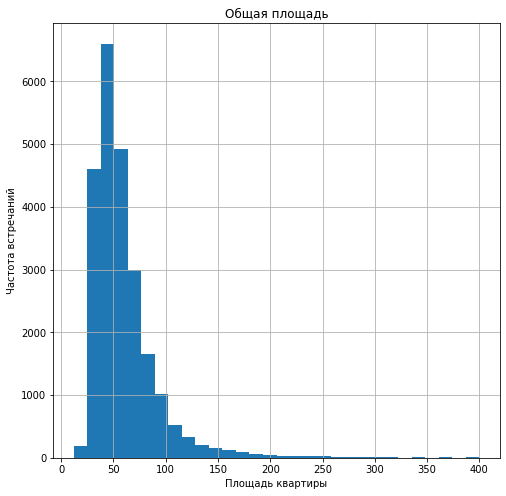

In [21]:
#проверила сколько объектов больше 200 кв м площадью
print('Количество объектов площадью более 200 м = ', len(data.query('total_area > 200'))) 
#гистограмма общей площади, ограничена 400 кв м 
data.query('total_area <= 400').hist('total_area',bins=30, figsize=(8,8)) 
plt.title('Oбщая площадь')
plt.xlabel('Площадь квартиры')
plt.ylabel('Частота встречаний')
plt.show()


**общая площадь** - в основном представлены объекты площадью от 30 до 60 кв. м., большие объекты более 200 кв м представлены уже в единичном кол-ве - их всего во всей базе 227 штук, максимальное кол-во кв м составляет 900, данное значение выглядит очень большим для квартиры, но тем не менее утверждать, что это ошибка, оснований нет;

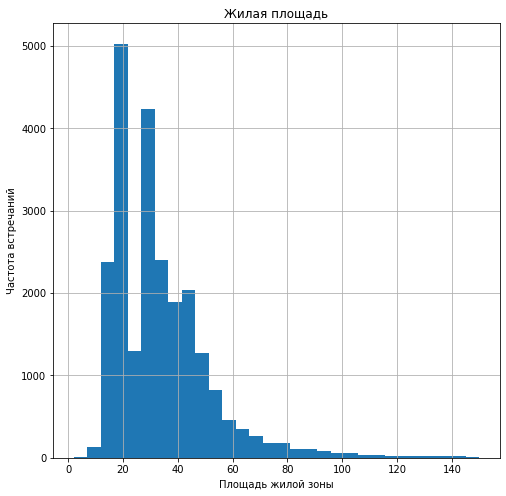

In [22]:
#гистограмма жилой площади, ограничена 150 кв м для наглядности
data.query('living_area <= 150').hist('living_area',bins=30, figsize=(8,8))
plt.title('Жилая площадь')
plt.xlabel('Площадь жилой зоны')
plt.ylabel('Частота встречаний')
plt.show()


**жилая площадь** - лежит в диапазоне от 15 до 40 кв м, что выглядит логичным, учитывая общую площадь. Однако, были обнаружены 10 объектов, общая площадь которых в 3 раза превышает сумму площадей жилой зоны и кухни, что выглядит подозрительно. А также 64 объекта, где сумма площадей жилой зоны и кухни выше чем общая площадь, так как этих квартир всего 74 штуки в общем это менее полупроцента я не исключала их из анализа.

Количество объектов, в которых кухни больше 60 кв м:  34


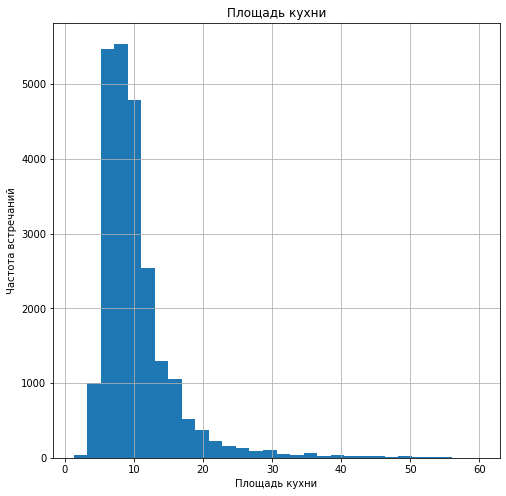

In [23]:
#проверила сколько объектов в которых кухни больше 60 кв м
print('Количество объектов, в которых кухни больше 60 кв м: ', len(data.query('kitchen_area > 60')))
#гистограмма площади кухни, ограничена 60 кв м для наглядности
data.query('kitchen_area <= 60').hist('kitchen_area',bins=30, figsize=(8,8))
plt.title('Площадь кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Частота встречаний')
plt.show()


**площадь кухни** - наиболее часто на кухни приходится 5 - 11 квадратных метров. Кухни свыше 30 квадратных метров представлены уже единичными объектами. Максимальная кухня составляет 112 квадратных метров, что само по себе конечно очень много, кухни более 60 кв м представлены 34 объектами.

In [24]:
#срез по аномалиям в площади - общая площадь меньше чем жилая и кухни
display(data[['total_area', 'living_area', 'kitchen_area']].query('total_area<living_area or total_area<kitchen_area or total_area<living_area+kitchen_area')) 
#срез по аномалиям -  общая площадь более чем в 3 раза больше жилой и кухни - тоже странно
display(data[['total_area', 'living_area', 'kitchen_area']].query('total_area/(living_area+kitchen_area) > 3'))

,total_area,living_area,kitchen_area
184,30.20,26.10,6.200000
424,98.00,88.00,16.986667
440,27.11,24.75,4.699067
545,23.80,20.00,5.000000
551,31.59,30.55,9.280000
...,...,...,...
22246,27.30,23.30,4.732000
22907,228.00,200.00,39.520000
23102,66.00,55.50,11.440000
23191,18.90,16.00,3.276000


,total_area,living_area,kitchen_area
8325,52.0,9.0,6.000000
9471,78.0,12.5,8.500000
13915,52.0,2.0,9.000000
14991,413.5,74.2,13.900000
17753,117.3,23.6,12.900000
18701,165.2,41.1,13.400000
21338,190.0,43.0,13.000000
21758,23.0,2.0,3.986667
21943,77.6,5.4,9.800000
23394,92.0,13.0,10.000000


Были обнаружены 10 объектов, общая площадь которых в 3 раза превышает сумму площадей жилой зоны и кухни, что выглядит подозрительно. А также 64 объекта, где сумма площадей жилой зоны и кухни выше чем общая площадь, так как этих квартир всего 129 штуки в общем, это менее полупроцента, я не исключала их из анализа.

Количество объектов больше 60 млн рублей равно 101


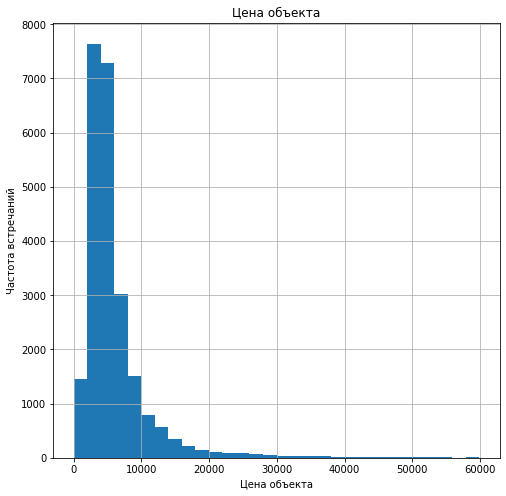

In [25]:
#проверила сколько объектов дороже 60 млн руб.
print('Количество объектов больше 60 млн рублей равно', len(data.query('k_price > 60000')))
#гистограмма ограничена 60 млн руб. для наглядности
data.query('k_price <= 60000').hist('k_price',bins=30, figsize=(8,8))
plt.title('Цена объекта')
plt.xlabel('Цена объекта')
plt.ylabel('Частота встречаний')
plt.show()


**цена объекта** - кол-во квартир стоимостью от 60 млн до 738 не превышает 1% - не брала их в расчет при строинии гистограммы. В основном стоимость квартир лежит в диапазоне до 9 млн рублей, что выглядит логичным, учитывая популярность квартир площадью от 30 до 60 кв.

Количество объектов, в которых больше 6 комнат равно 90
Количество объектов, где комнаты меньше 8 кв м равно 0


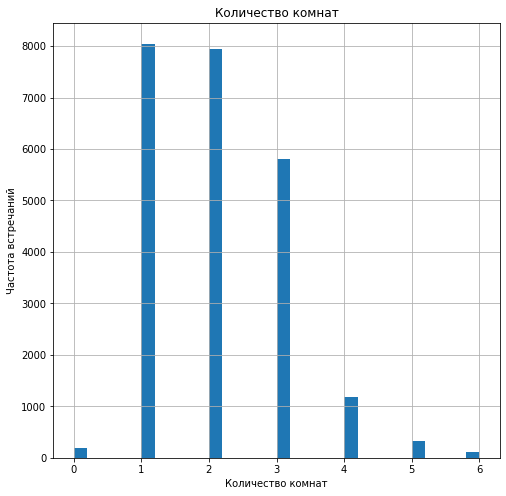

In [26]:
#проверка на существенность кол-ва многокомнатных квартир
print('Количество объектов, в которых больше 6 комнат равно', len(data.query('rooms > 6')))
#проверка есть ли квартиры, где кол-во комнат несоразмерно площади - примерно определили 8 кв м на комнату
print('Количество объектов, где комнаты меньше 8 кв м равно', len(data.query('total_area/rooms < 8'))) 
#гистограмма ограничена 6 комнатами для наглядности
data.query('rooms <= 6').hist('rooms', bins=30, figsize=(8,8))
plt.title('Количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Частота встречаний')
plt.show()


**количество комнат** - максимальное количество комнат равно 19, число выглядит очень большим, но в результате проверки было выявлено, что во-первых, доля объектов, где кол-во комнат больше 6, не превышает 1%, а во-вторых, нет объектов, в которых бы кол-во комнат выглядело бы ошибочным по сравнению с площадью. В основном представлены объекты, в которых 1-2-3 комнаты.

Количество объектов, в которых больше 25 этажей равно 342
Доля объектов высотой 5 и 9 этажей - 20%


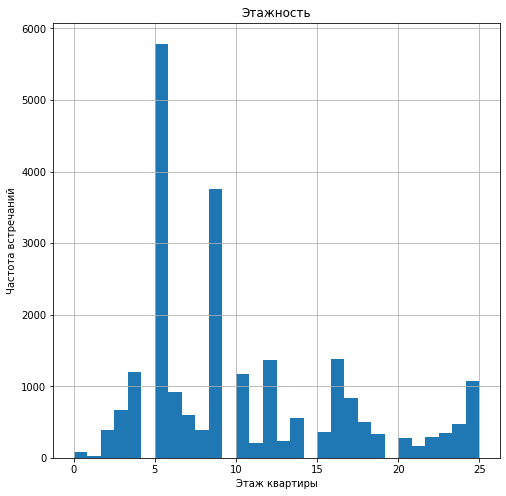

In [27]:
#проверка на существенность кол-ва многоэтажных домов
print('Количество объектов, в которых больше 25 этажей равно', len(data.query('floors_total_adj > 25')))
#расчет для комментария
print('Доля объектов высотой 5 и 9 этажей - {floor:.0%}'.format(floor=(len(data.query('floors_total_adj == 6 or floors_total_adj == 9'))/len(data['floors_total_adj']))))
#гистограмма ограничена 25 этажами для наглядности
data.query('floors_total_adj <= 25').hist('floors_total_adj' ,bins=30, figsize=(8,8))
plt.title('Этажность')
plt.xlabel('Этаж квартиры')
plt.ylabel('Частота встречаний')
plt.show()

**общее количество этажей в доме** - макс кол-во этажей в доме 60, всего объектов свыше 30 этажей 32, а больше 25 - 342, что в процентном соотношении около 1%. Рассматривая только этажность более 25 видно, что в основном в продаже были объекты высотой 5 и 9 этаже - их около 20% в общем объеме - больше 3500 объектов.

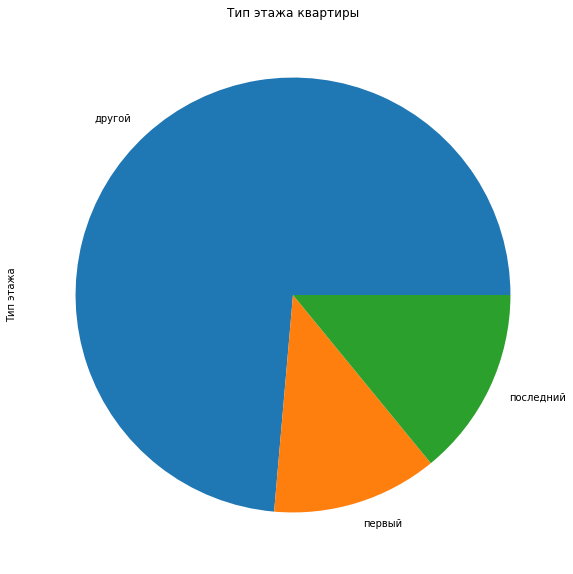

In [28]:
data.pivot_table(index='floor_type',values='locality_name',aggfunc='count').plot(y='locality_name',kind='pie',figsize=(10,10),label='Тип этажа',legend=False)
plt.title('Тип этажа квартиры')
plt.show()

В основном продаются квартиры на промежуточных этажах. Учитывая большую долю многоэтажных домов, ожидала, что на  на первый и последний этажи будет приходится меньшая доля квартир, но согласно графику видно, что более четверти квартир приходятся на 1 и послдений этажи.   

Количество объектов, в которых высота потолка от 5 до 100 метров:  39
Количество объектов, в которых высота потолка до 2 метров:  3


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,floors_total_adj,corrected_name,sq_meter_price,day_of_week,month_of_exposition,year_of_exposition,floor_type,km_to_city_center,k_price
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2,27.5,1,False,...,248.0,2,поселок Мга,35046.73,0,8,2017,первый,NaN,1500.0
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37,17.4,5,False,...,71.0,37,Санкт-Петербург,102500.00,1,10,2017,другой,20.0,4100.0
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12,32.4,7,False,...,13.0,12,Санкт-Петербург,109090.91,2,10,2018,другой,14.0,6000.0


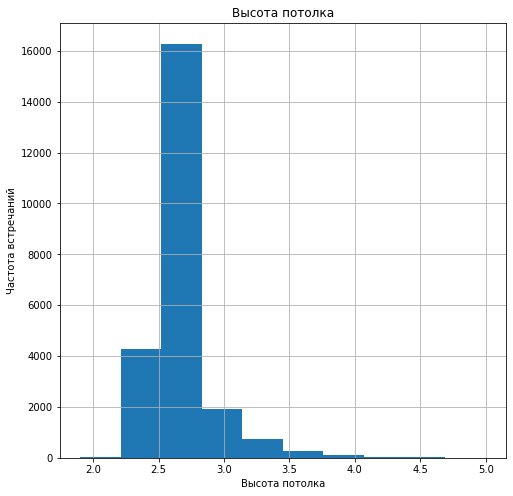

In [29]:
#высоту потолка больше 100 разделила на 10 - так она выглядит правдоподобнее
data.loc[data['ceiling_height'] > 100, 'ceiling_height'] = data['ceiling_height']/10 
#проверила объекты где высота потолка больше 5, но меньше 100
print('Количество объектов, в которых высота потолка от 5 до 100 метров: ', len(data.query('5 < ceiling_height < 100')))
#проверила высоту потолка меньше 2 метров
print('Количество объектов, в которых высота потолка до 2 метров: ', len(data.query('ceiling_height < 2'))) 
#высоту потолка меньше 2х метров выглядит странно
display(data.query('ceiling_height < 2'))
#гистограмма ограничены адекватрыми значениями высоты до потолка
data.hist('ceiling_height', range=(1.9,5), figsize=(8,8))
plt.title('Высота потолка')
plt.xlabel('Высота потолка')
plt.ylabel('Частота встречаний')
plt.show()


**высота потолков** - объекты, высота потолка которых была более 100 м, разделила на 10, тем не менее остались квартиры с высотой потолков 10 метров, что тоже не выглядит правдоподобно, как и квартиры с высотой потолков менее 2 метров - их в совокупности 41 штук, данное кол-во несущественно влияет на анализ, так как остальные параметры выглядят правдоподобно не удаляля их. Как и ожидалось, в основном у объектов высота потолков стремится к 2.5 м - 2.7м. Квартиры с потолками свыше 4 м представлены в малом количестве. Однако в данном столбце было много пропущенных значений (около 9000, что в целом искажает данные), но высота потолков зависит от типа дома, который в свою очередь может зависить от года постройки, но не от расположения, поэтому заполнив все значения медианой, мы все равно исказили бы анализ популяризировав медианное значение.  

Доля объектов, которые удалены от центра на более 30 км - 6%


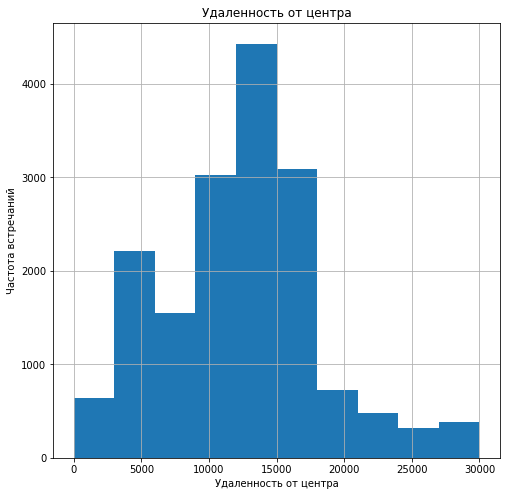

In [30]:
#проверили объекты, которые удалены от центра на более 30 км
print('Доля объектов, которые удалены от центра на более 30 км - {share:.0%}'.format(share=(len(data.query('cityCenters_nearest > 30000'))/len(data['cityCenters_nearest']))))
#Построили гистограмму по объектам до 30 км и которые не NaN
data.query('cityCenters_nearest < 30000 and not cityCenters_nearest.isna()').hist('cityCenters_nearest', range=(0,30000), figsize=(8,8))
plt.title('Удаленность от центра')
plt.xlabel('Удаленность от центра')
plt.ylabel('Частота встречаний')
plt.show()

**расстояние до центра города в метрах** - доля объектов, удаленных  от центра на расстоянии более чем 30 км - 6% - исключила их из гистограммы. Наиболее часто встречаются объекты, удаленные от центра на 10 - 17 км. Объекты, которые располагаются в центре встречаются редко - почти также редко как удаленные на 20-25-30 км.

Доля объектов, которые удалены от парков на более чем 1 км - 2%


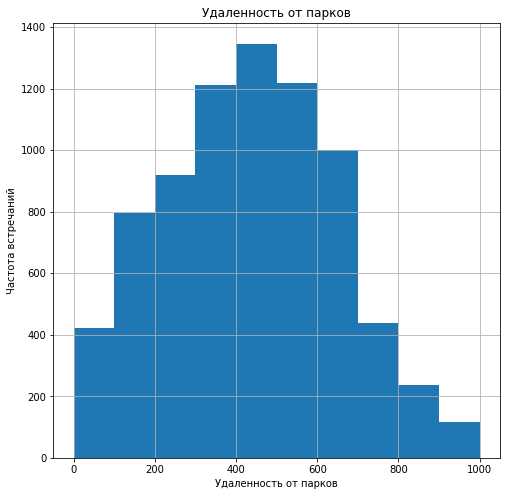

In [31]:
#проверили объекты, которые удалены от парков на более чем 1 км
print('Доля объектов, которые удалены от парков на более чем 1 км - {share:.0%}'.format(share=(len(data.query('parks_nearest > 1000'))/len(data['parks_nearest']))))
#Построили гистограмму по объектам до 1 км и которые не входят в список странных строк
data.query('0 < parks_nearest < 1000 and not parks_nearest.isna()').hist('parks_nearest', range=(0,1000), figsize=(8,8))
plt.title('Удаленность от парков')
plt.xlabel('Удаленность от парков')
plt.ylabel('Частота встречаний')
plt.show()

**расстояние до ближайшего парка** - парки, которые располагаются на удаленности более 1 км составляют 1%- их исключила из анализа. В основном парки находятся на расстоянии 300-700 метров.

In [32]:
#пивот по days_exposition, выявили регионы без значений по days_exposition
time_of_sales = (
    data.pivot_table(index='corrected_name',values='days_exposition',aggfunc=['mean','median','count'])
    .round(0)
)
time_of_sales.columns = ['av_days','median_days','exposition_qty']
time_of_sales = time_of_sales.query('exposition_qty not in  exposition_qty.isna()')
#создала датафрейм, чтобы значения corrected_name были обычным столбцом, не индексами 
time_of_sales_df = (
    pd.DataFrame({
        'corrected_name':time_of_sales.index, 
        'av_days':time_of_sales['av_days'],
        'median_days':time_of_sales['median_days'],
        'exposition_qty':time_of_sales['exposition_qty']
})
)

#Отфильтровала и отсортировала таблицу - описываю в комментарии
time_of_sales_df = (
    time_of_sales_df.query('exposition_qty > 20')
    .sort_values(by='av_days',ascending=False)
    .reset_index(drop=True)
)
display(time_of_sales_df.head(10)) #Для проверки


,corrected_name,av_days,median_days,exposition_qty
0,Волосово,280.0,114.0,31
1,Павловск,248.0,134.0,31
2,Коммунар,247.0,126.0,74
3,Локация_не_определена,239.0,211.0,48
4,Никольское,236.0,123.0,77
5,Приозерск,236.0,162.0,51
6,Ломоносов,219.0,124.0,114
7,Шлиссельбург,212.0,102.0,45
8,Пушкин,210.0,130.0,307
9,Сестрорецк,209.0,113.0,163


Около 3 тысяч значений пропущено в столбце days_exposition, которые оказывают влияние на среднюю. В ходе анализы изначально мной были выделены жилые регионы, где нет значений в столбце days_exposition, они были удалены из новой таблицы time_of_sales, так как все равно не дают никакой ясности в исследуемом вопросе.
    
Далее на основании отфильтрованных данных time_of_sales был создан датафрейм, в ходе исследования которого было выяснено, что по части поседков/городов было очень мало продаж, что скорее всего тоже будет искажать вывод, так как продажи по данным регионам - это редкость. 

В результате мы получили массив, который содержит в себе все еще 94% изначальной информации, но при этом около 13% значений отсутствуют, влияя на среднюю - удалила их из рассматриваемых данных.

Доля городов, где кол-во показов превышает 25 в общем объеме:  0.9405460145997722
Доля строк, где не указано сколько дней было размещено объявлени:  0.12794975325257962
Средний срок продажи, исходя из рассматриваемых данных:  180.02119559625476
Медиана срока продаж, исходя из рассматриваемых данных:  94.0
count    19438.000000
mean       180.021196
std        219.889161
min          1.000000
25%         44.000000
50%         94.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64


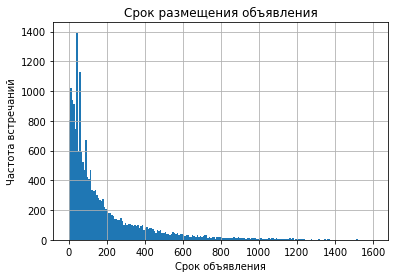

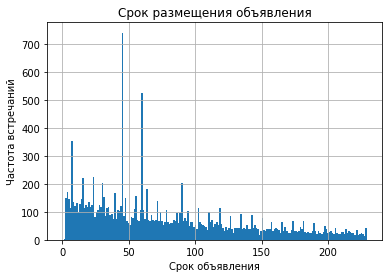

In [33]:
print('Доля городов, где кол-во показов превышает 25 в общем объеме: ',len(data.query('corrected_name in @time_of_sales_df.corrected_name'))/len(data))
print('Доля строк, где не указано сколько дней было размещено объявлени: ',len(data.query('corrected_name in @time_of_sales_df.corrected_name and days_exposition.isna()'))/len(data.query('corrected_name in @time_of_sales_df.corrected_name')))

#Отфильтровала DATA, оставив только те наименования, которые есть в отфильтрованном датафрейме time_of_sales_df
#и по которым нет пропусков в рассматриваемом столбце
filtered_data = data.query('corrected_name in @time_of_sales_df.corrected_name and not days_exposition.isna()')
print('Средний срок продажи, исходя из рассматриваемых данных: ', filtered_data['days_exposition'].mean())
print('Медиана срока продаж, исходя из рассматриваемых данных: ', filtered_data['days_exposition'].median())
print(filtered_data['days_exposition'].describe()) #Для более подробного изучения данных

filtered_data.hist('days_exposition',bins=200,range=(0,1600)) #Гистограмма со всеми значениями
plt.title('Срок размещения объявления')
plt.xlabel('Срок объявления')
plt.ylabel('Частота встречаний')
plt.show()
filtered_data.hist('days_exposition',bins=200,range=(0,229)) #Гистограмма до 300 дней по оси Х - так лучше видно
plt.title('Срок размещения объявления')
plt.xlabel('Срок объявления')
plt.ylabel('Частота встречаний')
plt.show()

Согласно анализу среднее кол-во дней, за которые была продана квартира, равна 180 дням, медианное значение почти в два раза меньше и равно 94, это означает, что есть выделяющиеся из общей массы значения, которые являются нестандартными для рассматриваемого массива данных. Согласно гистограмме наиболее много квартир было продано в срок 45, 60 дней, однако, данные сроки нельзя считать средними, скорее быстрыми (25% квартир продаются в срок до полутора месяцев). В выводе описания массива (метод describe) видно, что в половине случаев квартиры продавались в срок до 3 месяцев и 75% в срок до 7,5 месяцев. Свыше 7,5 месяцев (>229 дней) квартиры продаются в 1/4 случаев, из которых продажи свыше 600 дней осуществляются в редких случаев.

In [34]:
#для удобства взяла из первоначальных данных только нужные столбцы
table_for_corr = data[['total_area', 'living_area', 'kitchen_area','rooms','floor_type','day_of_week','month_of_exposition','year_of_exposition','k_price']]

#таблица корреляции всего с k_price
display('***Таблица корреляции k_price с остальными компонентами***',table_for_corr.corr().loc['k_price']) 
display(table_for_corr.head())

'***Таблица корреляции k_price с остальными компонентами***'

total_area             0.653675
living_area            0.585891
kitchen_area           0.513710
rooms                  0.363343
day_of_week            0.001550
month_of_exposition    0.002779
year_of_exposition    -0.043089
k_price                1.000000
Name: k_price, dtype: float64

,total_area,living_area,kitchen_area,rooms,floor_type,day_of_week,month_of_exposition,year_of_exposition,k_price
0,108.0,51.000000,25.00,3,другой,3,3,2019,13000.0
1,40.4,18.600000,11.00,1,первый,1,12,2018,3350.0
2,56.0,34.300000,8.30,2,другой,3,8,2015,5196.0
3,159.0,91.730769,27.56,3,другой,4,7,2015,64900.0
4,100.0,32.000000,41.00,2,другой,1,6,2018,10000.0


Как видно из таблицы корреляции last_price с остальными компонентами, дата размещения - будь то день недели, месяц или год - не влияет на общую стоимость. Коэффициент корреляции минимален и стремится к 0, не строю графики для этих категорий. В таблице также видно, что самая большая корреляция наблюдается с общей площадью.   
    
Ниже построила графики для всех параметров, по которым в таблице существует корреляция, а также по столбцу floor_type. 

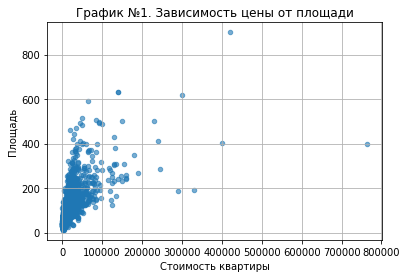

In [35]:
#Вводный график, чтобы отсечь нестандартные единичные высокие цены
table_for_corr.plot(x='k_price', y='total_area', kind='scatter', xlabel='Стоимость квартиры', ylabel='Площадь',  alpha=0.6, grid=True, sharex=False)
plt.title('График №1. Зависимость цены от площади')
plt.show()


Согласно Графику №1 взаимосвязи цены и общей площади видно, что значения более 200 млн уже единичны, поэтому для прослеживавния взаимосвязи и наглядности последующие графики ограничены по оси Х до 200 000 тыс. руб. 

***Корреляция общей площади и площади кухни*** 0.6601347396052482
***Корреляция общей площади и жилой площади*** 0.9462534256263033


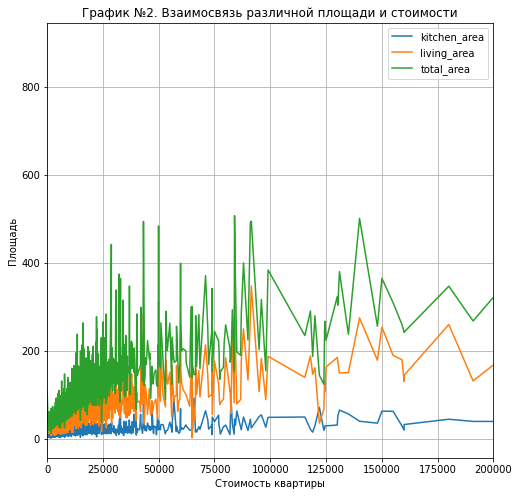

In [36]:
print('***Корреляция общей площади и площади кухни***',table_for_corr['kitchen_area'].corr(table_for_corr['total_area']))
print('***Корреляция общей площади и жилой площади***',table_for_corr['living_area'].corr(table_for_corr['total_area']))
#Построили график зависимости различной площади и стоимости
table_for_corr.pivot_table(index='k_price',values=['total_area','living_area','kitchen_area']).plot(xlim=(0,200000), grid=True, xlabel='Стоимость квартиры', ylabel='Площадь', figsize=(8,8), sharex=False)
plt.title('График №2. Взаимосвязь различной площади и стоимости')
plt.show()


На Графике №2, отражающем взаимосвязь различной площади и стоимости видно, что несмотря на видимый рост цены в связи с ростом общей площади и отдельных площадей жилой зоны и кухни, это не единственные факторы, влияющие на цену - мы видим выбивающиеся из стройного графика пики. Также существует взаимосвязь между площадью кухни и общей площадью, поэтому утверждать, что стоимость квартир зависит от площади кухни сложно. Скорее всего площадь кухни коррелирует с общей/жилой площадью, которые коррелирует со стоимостью. Тоже самое можно сказать и о жилой площади, корреляция между жилой площадью и общей площадью почти 100% (коэффициент равен 0.94). Очевидно, что стоимость квартиры зависит от метража, но скорее общего или жилого, нежели от метража кухни. В таблице с корреляцией мы видим, что корреляция с общей площадью сильнее чем с остальными площадами, коэффициент корреляции с площадью кухни и вовсе имеет пограничное значение - 0.5.

***Корреляция кол-ва комнат и жилой площади*** 0.8267955023522257
***Корреляция кол-ва комнат и общей площади*** 0.7583438234725666


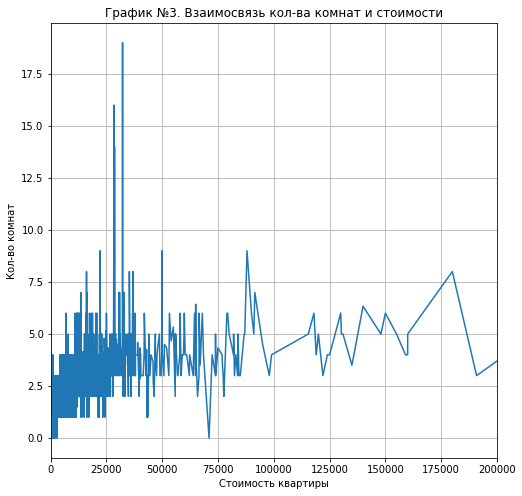

In [37]:
print('***Корреляция кол-ва комнат и жилой площади***',table_for_corr['rooms'].corr(table_for_corr['living_area']))
print('***Корреляция кол-ва комнат и общей площади***',table_for_corr['rooms'].corr(table_for_corr['total_area']))
#Построили график зависимости кол-ва комнат и стоимости
table_for_corr.pivot_table(index='k_price',values='rooms').plot(xlim=(0,200000), figsize=(8,8), legend=False, xlabel='Стоимость квартиры', ylabel='Кол-во комнат', grid=True, sharex=False)
plt.title('График №3. Взаимосвязь кол-ва комнат и стоимости')
plt.show()


На Графике №3, отражающем взаимосвязь кол-ва комнат и стоимости, видно, что стоимость с ростом кол-ва комнат конечно растет, но очень слабо, большинство данных графика мы видим в диапазоне между 2 и 5 комнатами, распределенном практически по всему диапазону цен. Также кол-во комнат коррелирует с жилой и общей площадью (коэфф.корр.: 0.85 и 0.76 соответственно), что конечно увеличивает и цену, но прямая корреляция достаточно слабая - в таблице с корреляцией мы видим коэффициент 0.36.

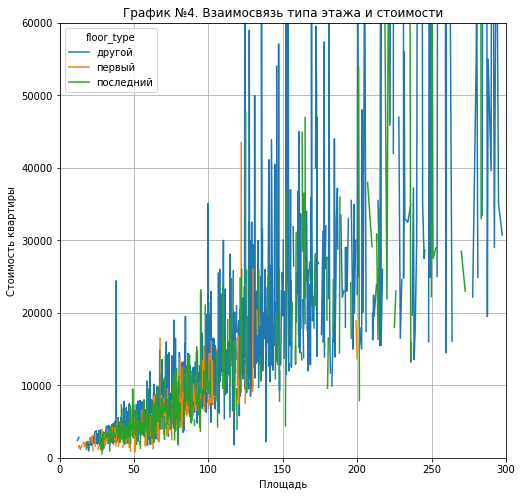

In [38]:
#Построили график зависимости типа этажа и стоимости
table_for_corr.pivot_table(index='total_area',columns='floor_type', values='k_price',aggfunc='median').plot(xlim=(0,300), ylim=(0,60000), xlabel='Площадь', ylabel='Стоимость квартиры', figsize=(8,8), grid=True, sharex=False)
plt.title('График №4. Взаимосвязь типа этажа и стоимости')
plt.show()

На Графике №4 отображена зависимость между типом этажа, общей площадью и стоимостью. Данный график для наглядности обрезан по оси x до 300 метров и по оси y до 60 млн руб. График был построен мной таким образом, чтобы увидить будут ли отдельные графики по первым и последним этажам сильно отклоняться от графика по промежуточным этажам. На мой взгляд несмотря на некоторые выбивающиеся объекты на первых этажах по почти 45 млн и 25 млн, основная масса квартир на первом этаже находится в диапазоне до 15 млн, тогда как квартиры на промежуточных этажах доходят часто и до 25 млн. Оранжевый график располагается заметно ниже синего, что говорит о том, что взаимосвязь все же присутствует и квартиры на первом этаже продаются дешевле, чем на промежуточных, но не 100%-ная. Квартиры на последних этажах продаются также чуть дешевле в общей массе, чем на промежуточных, но мы видим, что довольно часто на последних этажах продаются большие и дорогие квартиры, в отличии от оранжевого графика зеленый простирается гораздо дальше по области графика. 

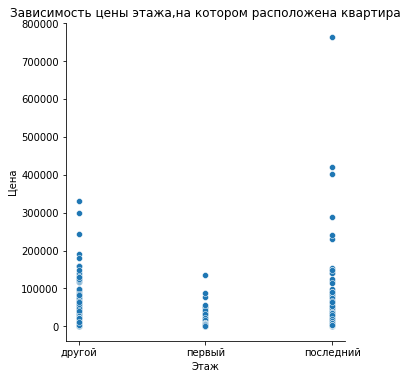

In [39]:
# Код ревьюера

import seaborn as sns
import numpy as np

sns.relplot(x='floor_type', y='k_price', data=data)
total_area=np.linspace(0,20)
plt.title('Зависимость цены этажа,на котором расположена квартира')
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.show()

In [40]:
#построила пивот, посчитала среднюю цену и кол-во объявлений
sq_meters_analysis = data.pivot_table(index='corrected_name',values='sq_meter_price',aggfunc=['mean','count']) 
sq_meters_analysis.columns = ['mean_price','count'] #переименовала колонки
#определила топ-10 кол-ва объявлений
display(sq_meters_analysis.sort_values(by='count',ascending=False).head(10)) 

print('Всего парков ',sq_meters_analysis['count'].sum(),' из 23699') #проверка на полноту


,mean_price,count
corrected_name,,
Санкт-Петербург,114849.008793,15721
поселок Мурино,85681.762572,556
поселок Шушары,78677.364318,440
Всеволожск,68654.473970,398
Пушкин,103125.819377,369
Колпино,75424.579112,338
поселок Парголово,90175.913089,327
Гатчина,68746.146515,307
деревня Кудрово,92473.547559,299


Всего парков  23699  из 23699


In [41]:
top_ten = 236  #создала переменную и присвоила значение, в которое входит топ 10

#построили таблица, расположив среднюю цену по убыванию
top_sq_meters_analysis = sq_meters_analysis.query('count > @top_ten').sort_values(by='mean_price',ascending=False)
display(top_sq_meters_analysis)

max_price = top_sq_meters_analysis['mean_price'].max().round(2) #максимальная цена
max_price_region = top_sq_meters_analysis['mean_price'].idxmax() #регион, соответствующий максимальной цене
min_price = top_sq_meters_analysis['mean_price'].min().round(2) #минимальная цена
min_price_region = top_sq_meters_analysis['mean_price'].idxmin() #регион, соответствующий минимальной цене
print(f'В регионе {max_price_region} самая высокая стоимость квадратного метра {max_price}')
print(f'В регионе {min_price_region} самая низкая стоимость квадратного метра {min_price}')


,mean_price,count
corrected_name,,
Санкт-Петербург,114849.008793,15721
Пушкин,103125.819377,369
деревня Кудрово,92473.547559,299
поселок Парголово,90175.913089,327
поселок Мурино,85681.762572,556
поселок Шушары,78677.364318,440
Колпино,75424.579112,338
Гатчина,68746.146515,307
Всеволожск,68654.473970,398


В регионе Санкт-Петербург самая высокая стоимость квадратного метра 114849.01
В регионе Выборг самая низкая стоимость квадратного метра 58141.91


Самая высокая стоимость квартир в ленинградской области ожидаемо в Санкт-Петербурге, где средняя стоимость квадратного метра равна почти 115 тыс.рублей. Самая низкая стоимость квадратного метра в топ-10 популярных регионов в Выборге, стоимость кв метра здесь равна 58 тыс.рублей.

,av_price,median
km_to_city_center,,
0.0,31449.12,17900.0
1.0,21206.72,11395.0
2.0,17788.32,10000.0
3.0,11126.58,8409.0
4.0,13304.28,9200.0
5.0,14499.12,9500.0
6.0,15338.42,8900.0
7.0,14775.15,7800.0
8.0,9957.72,7450.0


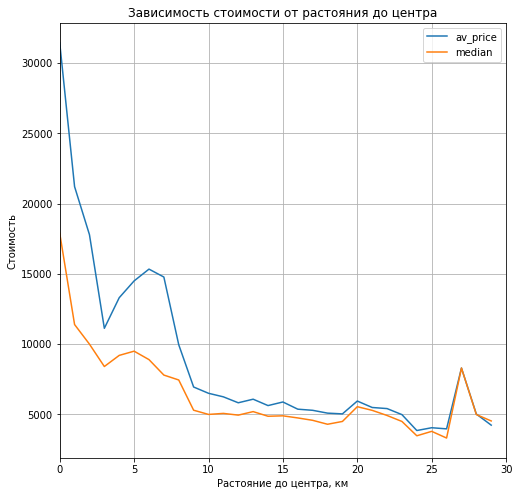

In [42]:
#создала переменную, хранящую срез данных со средней и медианной ценой
spb_flats = data.query('locality_name == "Санкт-Петербург" and not km_to_city_center.isna()').pivot_table(index='km_to_city_center',values='k_price',aggfunc=['mean','median']).round(2) 
spb_flats.columns = ['av_price','median'] 
display(spb_flats.head(10))
spb_flats.plot(xlim=(0,30), grid=True, xlabel='Растояние до центра, км', ylabel='Стоимость', figsize=(8,8)) #построила график зависимости цены от удаленности
plt.title('Зависимость стоимости от растояния до центра')
plt.show()

Ожидаемо стоимость квартир снижается, чем дальше кватира находится от центра. Однако на графике видно, что есть аномальные отклонения, например: 
 - квартиры, находящиеся на расстоянии 4-7 км не имеют такой прямой корреляции и явно выше по стоимости, чем квартиры, удаленные на 3 км, что также может говорить о рекордно низких ценах на некоторые квартиры в радиусе 3 км от центра;
 - также квартиры, удаленные на 24 км имеют стоимость ниже, чем удаленные на 25 и 26 км, а дорогие квартиры удаленные на 27 км также выглядят неоднозначно. 

На графике отображены средняя цена и медиана, на основании двух линейных графиков можно сделать вывод, что в случае 4-7 км есть квартиры сильно выбивающиеся из общего диапазона цен, но в целом медианные значения выглядят схожими со средними. Однако, чем ближе к центру тем больше квартир с отдеными ценовыми выбросами.     

### Напишите общий вывод

В ходе проведенного анализа и обработки данных были добавлены необходимые для анализа столбцы, заменены некоторые пропуски. Достаточно значительная часть пропусков по паркам, прудам и центру не была исправлена или удалена, так как кол-во достаточно большое, а подставление среднего или медианного значение может исказить анализ, так как опять же кол-во их существенное. В ходе анализа также были найдены несоответствия по ряду параметров, в виду несущественности кол-ва они не были удалены из анализа - детально описано выше.

**В ходе анализа были сделаны следующие выводы:**
Подтверждена взаимосвязь удаленности от центра и снижению цены, посчитан коэфф корреляции и наглядно продемонстрирована взаимосвязь цены и площади объекта. Интересным и неожиданным для меня результатом стало исследование зависимости этажности (первый/последний/промежуточный) и стоимости. Квартиры на первом этаже продавались ожидаемо дешевле, а вот квартиры на последнем этаже такой очевидной корреляции не показали, более того жилые объекты на последний этажах иногда продаются за дорого и большой площади.
Общая площадь продаваемой недвижимости в среднем составляет 30-60 кв метров, что в целом подчиняется логике, обоснованным также выглядят резултаты по этажности в Петербурге и Лен. области, несмотря на наличие объектов 25-60 этажей (их кол-во не превышает 1.5 процентов) в основном застройка не высокая 6-10 этажей. 

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.